In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from rl_algos.ppo_continuous import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [12]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 64
num_updates = 2000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [13]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 2000 Updates
global update: 100
reward: -243.33246600101364
max pF: 1.3868773199053566
max photon: 8.57191177457571
photon time: 0.5926371701023201
smoothness: 0.006026297890429824
global update: 200
reward: -197.00618020624677
max pF: 2.5148521276937075
max photon: 30.327378183603287
photon time: 0.7569426177870469
smoothness: 0.005246787434035821
global update: 300
reward: -151.41713762864703
max pF: 2.558275741015254
max photon: 40.30983489751816
photon time: 0.786542372956347
smoothness: 0.004090203676542564
global update: 400
reward: -97.95804841547903
max pF: 2.5600845314817544
max photon: 40.2339483499527
photon time: 0.5703363886105739
smoothness: 0.0028968651643297336
global update: 500
reward: -62.19991264739431
max pF: 2.555672077064597
max photon: 39.85899329185486
photon time: 0.3714685371964248
smoothness: 0.002077173971764032
global update: 600
reward: -31.310627070923907
max pF: 2.5495121917298524
max photon: 40.22581523656845
photon time: 0.4057891458

In [6]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]

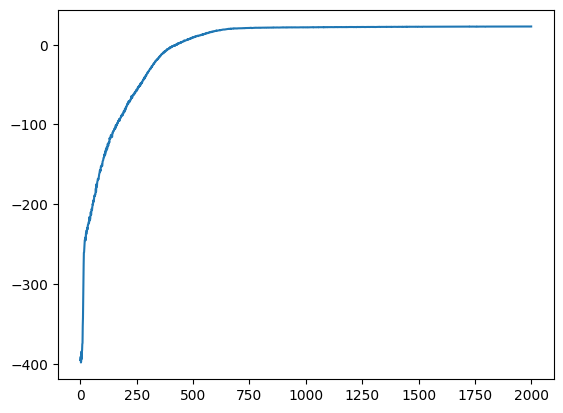

In [9]:
plt.plot(jnp.mean(rewards, axis=-1))
plt.show()

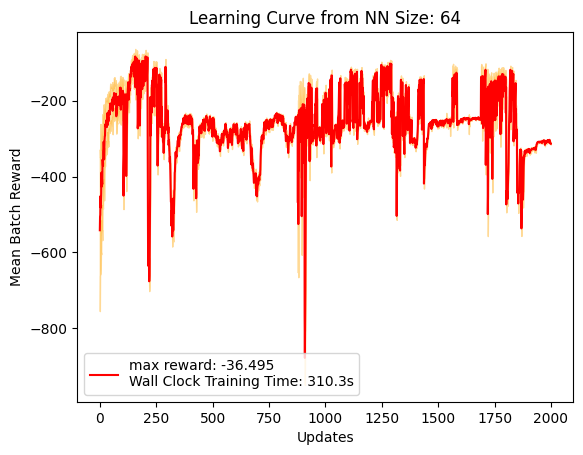

In [6]:
env_ind = 0
update_plot = 2000

x = np.arange(update_plot) # / update_plot * (end - start)
m_plot = mean_rewards[:update_plot, env_ind]
s_plot = std_reward[:update_plot, env_ind]

plt.plot(x, m_plot, label=f'max reward: {int(1e3 * max_rewards[-1,0]) / 1e3}\nWall Clock Training Time: {int(1e1 *(end - start)) / 1e1}s', color='red')
plt.fill_between(x, m_plot - s_plot, m_plot + s_plot, color='orange', alpha=0.4)
plt.legend()
plt.xlabel('Updates')
plt.ylabel('Mean Batch Reward')
plt.title(f'Learning Curve from NN Size: {config["LAYER_SIZE"]}')
plt.show()

(2000, 8, 121)
0.1375
0.5389893875270408
0.8181626928548356


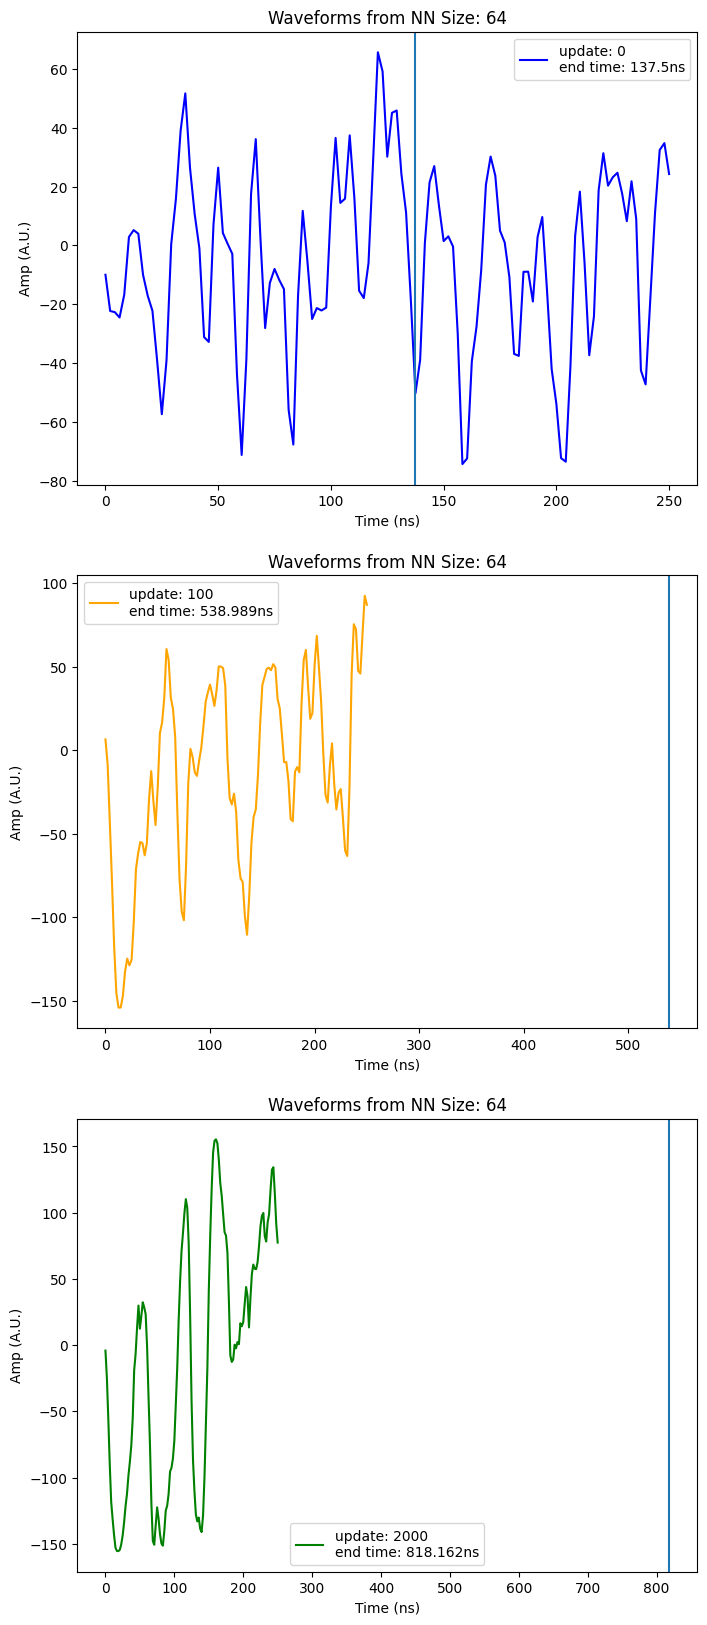

In [9]:
# Visualising Waveform Learning

plotting_updates = np.array([0, 100, 2000], dtype=np.int16)

print(max_actions.shape)

update_action = -max_actions[plotting_updates, 0]
action_linspace = np.linspace(0., num_t1 / kappa, update_action.shape[-1])

fig, ax = plt.subplots(len(plotting_updates), figsize=(8.0, 20.0))

color_list = ["blue", "orange", "green"]

for ind, action in enumerate(update_action):
    ax[ind].plot(action_linspace * 1e3, action, label=f'update: {plotting_updates[ind]}\nend time: {int(1e6 * max_times[plotting_updates[ind], 0]) / 1e3}ns', color=color_list[ind])
    ax[ind].axvline(x=1e6 * max_times[plotting_updates[ind], 0] / 1e3)
    print(max_times[plotting_updates[ind], 0])
    ax[ind].legend()
    ax[ind].set_xlabel('Time (ns)')
    ax[ind].set_ylabel('Amp (A.U.)')
    ax[ind].set_title(f'Waveforms from NN Size: {config["LAYER_SIZE"]}')
plt.show()